<a href="https://colab.research.google.com/github/Legucki/DataScience/blob/master/ComputerVision_GAN_Face_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ładowanie datasetu Celeba z kaggle**

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

Wczytaj plik kaggle.json:

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michalegucki","key":"dec10efc38cdf08c483ce48dd1520898"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:05<00:00, 231MB/s]
100% 1.33G/1.33G [00:05<00:00, 238MB/s]


In [ ]:
!unzip celeba-dataset.zip -d celeba

In [382]:
import os
import pickle
import sys

from keras import applications
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
import numpy as np
from PIL import Image

In [383]:
#Ścieżka do folderu ze zdjęciami w google colab:
PATH = '/content/'

In [384]:
#Parametry obrazów:
'''Zdefiniowany w tym miejscu rozmiar zdjęcia będzie przyjmowany jako 
input i output. Tej wielkości zdjęć będzie używał model do nauki 
i tej wielkości zdjęcia zostaną wygenerowane'''
IMG_SIZE = 32

#Parametry trenowania: 
BATCH_SIZE = 64
KERNEL_SIZE = 4

In [385]:
# Import biblioteki torch - na niej zostanie przeprowadzone modelowanie:
import torch
from torchvision import datasets
from torchvision import transforms

##**Generator danych do trenowania**

In [386]:
#DATA GENERATOR:

def get_dataloader(batch_size, image_size, data_dir=PATH):
  ''' Funkcja przygotowuje dane do podania partiami modelowi: 
  parametry:
          data_dir - ścieżka do folderu ze zdjęciami
          batch_size - wielkość batcha - tyle zdjęć wygeneruje do podania
          image_size - rozmiar docelowy zdjęcia

  '''
  #Obróbka zdjęć: 
  transform = transforms.Compose([
                                  transforms.Resize((image_size, image_size)),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
  ])

  dataset = datasets.ImageFolder(data_dir, transform=transform)
  image_transforms = transforms.Compose([
                                         transforms.Resize((image_size, image_size)),
                                         transforms.ToTensor()
  ])

  dataloader = torch.utils.data.DataLoader(datasets.ImageFolder(data_dir, transform=image_transforms), shuffle=True, batch_size=BATCH_SIZE)

  return dataloader

In [387]:
celeba_train_loader = get_dataloader(BATCH_SIZE, IMG_SIZE)

In [388]:
celeba_train_loader

In [389]:
import matplotlib.pyplot as plt
%matplotlib inline

##**Wyświetlenie przykładowych obrazów po obróbce**

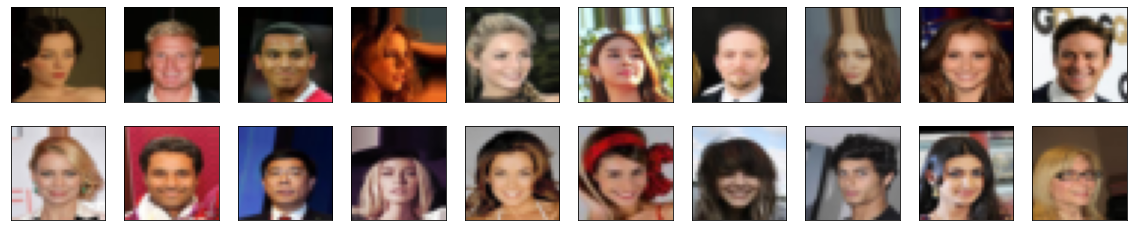

In [390]:
#WYŚWIETLANIE OBRAZÓW PRZYKŁADOWYCH:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

#Pobranie jednego batcha obrazów:
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()

fig = plt.figure(figsize=(20,4))
plot_size = 20
for idx in np.arange(plot_size):
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])

In [391]:
#Rozmiar jednego zdjęcia:
images[0].shape

torch.Size([3, 32, 32])

Rozmiar się zgadza - 3 kanały (RGB), rozmiar 32x32 pixele

In [392]:
#Przeskalowanie obrazów z wartości od 0 do 1 na -1 do 1:

def scale(x, feature_range=(-1,1)):
  min, max = feature_range
  x = x * (max-min) + min
  return x

In [393]:
print(images[0][0][0])
print(scale(images[0])[0][0])

tensor([0.0196, 0.0039, 0.0000, 0.0078, 0.0118, 0.0510, 0.1020, 0.1020, 0.1098,
        0.1216, 0.1569, 0.2627, 0.2314, 0.2118, 0.2627, 0.1882, 0.2980, 0.2706,
        0.2706, 0.2706, 0.2706, 0.2706, 0.2706, 0.2706, 0.2706, 0.2706, 0.2588,
        0.2588, 0.2627, 0.2627, 0.2627, 0.2549])
tensor([-0.9608, -0.9922, -1.0000, -0.9843, -0.9765, -0.8980, -0.7961, -0.7961,
        -0.7804, -0.7569, -0.6863, -0.4745, -0.5373, -0.5765, -0.4745, -0.6235,
        -0.4039, -0.4588, -0.4588, -0.4588, -0.4588, -0.4588, -0.4588, -0.4588,
        -0.4588, -0.4588, -0.4824, -0.4824, -0.4745, -0.4745, -0.4745, -0.4902])


Wszystko wygląda dobrze - zdjęcia zostały przeskalowane z wartości od 0 do 1 na wartości od -1 do 1

#**Definiowanie modelu**

##**Dyskryminator**

In [459]:
import torch.nn as nn
import torch.nn.functional as F

In [460]:
def conv(in_channels, out_channels, kernel_size=KERNEL_SIZE, stride=2, padding=1, batch_norm=True):
  '''
      Funkcja tworząca warstwy konwolucyjne dla dyskryminatora
  '''
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [461]:
class Discriminator(nn.Module):

  '''
      Klasa dyskryminatora, który jako input przyjmuje zdjęcie w rozmiarze 32x32
      i ostatecznie na ostatniej warstwie daje output 0 / 1, który mówi, czy
      zdjęcie zostało zaklasyfikowane jako prawdziwe, czy fałszywe
  '''
  
  def __init__(self, conv_dim):
    super(Discriminator, self).__init__()
    self.conv_dim = conv_dim

    #Definiowanie warstw konwolucyjnych. Powinny akceptować input jako RGB i output jako pojedyńcza wartość (prawdziwe / fałszywe)

    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)

    #Output 16x16:
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
  
    #Output 8x8:
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    #Output 4x4:
    self.conv4 = conv(conv_dim*4, conv_dim*8, 4)

    #Output 2x2 i warstwa FullyConnected:
    self.fc = nn.Linear(conv_dim*8*2*2, 1)

    #Funkcja aktywacji Sigmoidalna dla ostatniego outputu:
    self.out = nn.Sigmoid()

    #Dropout w razie potrzeby:
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    #Propagacja przednia sieci neuronowej.
    out = F.leaky_relu(self.conv1(x), 0.2)
    out = F.leaky_relu(self.conv2(out), 0.2)
    out = F.leaky_relu(self.conv3(out), 0.2)
    out = F.leaky_relu(self.conv4(out), 0.2)

    out = out.view(-1, self.conv_dim*8*2*2)

    x = self.fc(out)

    return x
  

##**Generator**

In [462]:
def deconv(in_channels, out_channels, kernel_size=KERNEL_SIZE, stride=2, padding=1, batch_norm=True):
  '''
    Funkcja tworząca warstwę 'dekonwolucyjną' (bo to de facto nie jest to)
    na potrzeby generatora
  '''
  layers = []
  transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

  layers.append(transpose_conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [463]:
class Generator(nn.Module):
  '''
      Klasa generatora, który jako input przyjmuje szum,
      przerabia go na to, co wydaje mu się być zdjęciem osoby i przekazuje
      do dyskryminatora w celu oceny (nie do końca klasa to robi, ale niech będzie
      tak na razie :p )
  '''
  def __init__(self, z_size, conv_dim):
    '''
      parametr z_size jest wielkością, która definiuje długość wektora 
      'przestrzeni utajonej', która wpływa na output generatora
      parametr conv_dim - wymiar inputu dla ostatniej warstwy konwolucyjnej
    '''
    super(Generator, self).__init__()

    self.conv_dim = conv_dim
    #Warstwa fully connected
    self.fc = nn.Linear(z_size, conv_dim*8*2*2)

    self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
    self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
    self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
    self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)

  def forward(self, x):
    '''
        Przednia propagacja Sieci Neuronowej
        parametr x: input sieci
        zwraca: tensor 32x32x3 (obraz) jako output
    '''
    out = self.fc(x)

    out = out.view(-1, self.conv_dim*8, 2, 2)

    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))
    out = F.relu(self.deconv3(out))

    out = self.deconv4(out)
    x = torch.tanh(out)

    return x

##**Inicjalizacja wag:**

In [464]:
def weights_init_normal(m):
  """
  Przekazuje modelowi wstępne wagi dla wybranych warstw w modelu. Wagi są wzięte z rozkładu normalnego ze średnią = 0, odchyleniem standardowym = 0.02
  parametr m: Warstwa sieci
  """

  classname = m.__class__.__name__ # Nazwa danej warstwy

  #Jeżeli posiada dany atrybut i nazwę, to nadaje wagi:
  if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
    m.weight.data.normal_(0.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
      m.bias.data.zero_()

#**Budowanie kompletnej sieci:**

In [465]:
def build_network(d_conv_dim, g_conv_dim, z_size):
  #Tworzymy instancje Dyskryminatora i Generatora (robi się ciekawie!)
  D = Discriminator(d_conv_dim)
  G = Generator(z_size=z_size, conv_dim=g_conv_dim)

  #Inicjalizujemy wagi na klasach:
  D.apply(weights_init_normal)
  G.apply(weights_init_normal)

  print(D)
  print()
  print(G)
  #Zwracamy D i G:
  return D, G

In [466]:
#Definiujemy hiperparametry modelu:
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

#Budujemy sieć:
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (out): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 25

**Trenowanie na GPU:**

In [467]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print("Nie znaleziono GPU. Zmień środowisko na GPU i spróbuj ponownie!")
else:
  print('Trenowanie na GPU')

Trenowanie na GPU


##**Straty generatora i dyskryminatora**

In [468]:
import random
from random import randrange, uniform

#Funkcje zbierające straty podczas trenowania obu modeli:
def real_loss(D_out, smooth=False):
  
  batch_size = D_out.size(0)

  #Wygładzanie:
  if smooth:
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size)

  if train_on_gpu:
    labels = labels.cuda()
  
  #Binary Cross-Entropy with Logits Loss:
  criterion = nn.BCEWithLogitsLoss()

  loss = criterion(D_out.squeeze(), labels)

  return loss

def fake_loss(D_out):

  batch_size = D_out.size(0)

  labels = torch.zeros(batch_size)

  if train_on_gpu:
    labels = labels.cuda()
  
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)

  return loss


##**Optymizatory**

In [469]:
import torch.optim as optim
#Oczywiście Adam :D
d_optimizer = optim.Adam(D.parameters(), lr=0.0005, betas=(0.4, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0005, betas=(0.4, 0.999))

#**Trenowanie modelu:**

In [470]:
import pickle as pkl

In [473]:
def train(D, G, n_epochs=10, print_every=50):
  """Trenuje sieć GAN przez {n_epochs} liczbę razy.
  D - dyskryminator
  G - generator
  print_every - co ile kroków printować i zapisać lossy
  zwraca - lossy D i G"""

  #Poniższe polecenie sprawdza czy train_on_gpu == True, jeżeli tak to 
  #wrzuca obliczenia na GPU, powtarza się wielokrotnie
  if train_on_gpu:
    D.cuda()
    G.cuda()
  
  samples = []
  losses  = []

  #Przygotowujemy zafixowane dane - obrazy, które nie zmienią się przez okres trenowania i posłużą do ewaluacji sprawności modelu:
  sample_size = 16
  fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
  fixed_z = torch.from_numpy(fixed_z).float()

  if train_on_gpu:
    fixed_z = fixed_z.cuda()
  
  for epoch in range(n_epochs):
    for batch_i, (real_images, _) in enumerate(celeba_train_loader):
      batch_size = real_images.size(0)
      real_images = scale(real_images)

      d_optimizer.zero_grad()

      if train_on_gpu:
        real_images = real_images.cuda()
      #Trenowanie dyskryminatora na prawdziwych i fejkowych obrazach:
      #Obliczenie strat dyskryminatora:
      D_real = D(real_images)
      d_real_loss = real_loss(D_real)
      #Generowanie fejkowych obrazów:

      z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z_fake = torch.from_numpy(z_fake).float()

      if train_on_gpu:
        z_fake = z_fake.cuda()
      fake_images = G(z_fake)

      #Obliczenie strat generatora:
      D_fake = D(fake_images)
      d_fake_loss = fake_loss(D_fake)
      
      #Sumowanie strat i wsteczna propagacja:
      d_loss = d_real_loss + d_fake_loss
      d_loss.backward()
      d_optimizer.step()

      #Trenowanie Generatora:

      g_optimizer.zero_grad()

      #Generowanie fejkowych obrazów:
      z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z_fake = torch.from_numpy(z_fake).float()

      if train_on_gpu:
        z_fake = z_fake.cuda()
      fake_images = G(z_fake)

      D_fake = D(fake_images)

      g_loss = real_loss(D_fake, True)

      g_loss.backward()
      g_optimizer.step()

      if batch_i % print_every == 0:
        losses.append((d_loss.item(), g_loss.item()))
        print(f"Epoch: {epoch+1}/{n_epochs} | d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
      

    #Zapisywanie wygenerowanych obrazów w trakcie trenowania:
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()

  with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
  
  return losses



In [474]:
N_EPOCHS = 20
z_size = 100

losses = train(D, G, n_epochs = N_EPOCHS)

Epoch: 1/20 | d_loss: 0.12205339968204498, g_loss: 4.001136779785156
Epoch: 1/20 | d_loss: 0.1848110556602478, g_loss: 6.261077880859375
Epoch: 1/20 | d_loss: 1.8854601383209229, g_loss: 3.5254323482513428
Epoch: 1/20 | d_loss: 0.9633681178092957, g_loss: 2.448019504547119
Epoch: 1/20 | d_loss: 1.1025785207748413, g_loss: 1.7256337404251099
Epoch: 1/20 | d_loss: 1.2750211954116821, g_loss: 2.377953290939331
Epoch: 1/20 | d_loss: 1.220070481300354, g_loss: 2.5912983417510986
Epoch: 1/20 | d_loss: 0.9489209055900574, g_loss: 1.7237017154693604
Epoch: 1/20 | d_loss: 0.8482354879379272, g_loss: 1.8414716720581055
Epoch: 1/20 | d_loss: 1.0860321521759033, g_loss: 1.8146497011184692
Epoch: 1/20 | d_loss: 1.0901979207992554, g_loss: 1.457680106163025
Epoch: 1/20 | d_loss: 1.0566964149475098, g_loss: 1.9635744094848633
Epoch: 1/20 | d_loss: 1.0469911098480225, g_loss: 1.7404440641403198
Epoch: 1/20 | d_loss: 1.3916276693344116, g_loss: 1.6952383518218994
Epoch: 1/20 | d_loss: 1.115589618682861

##**Wykres przedstawiający straty generatora i dyskryminatora**

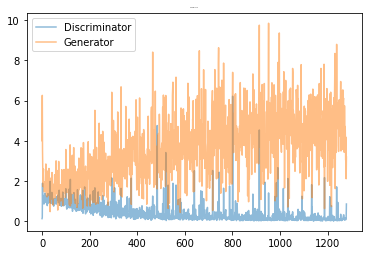

In [475]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Dyskryminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.legend()

In [476]:
# Fuknckja pomocnicza do wyświetlania sampli wygenerowanych twarzy
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [477]:
# Ładuje przykłady z generatora, które powstały podczas trenowania i spiklowane:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

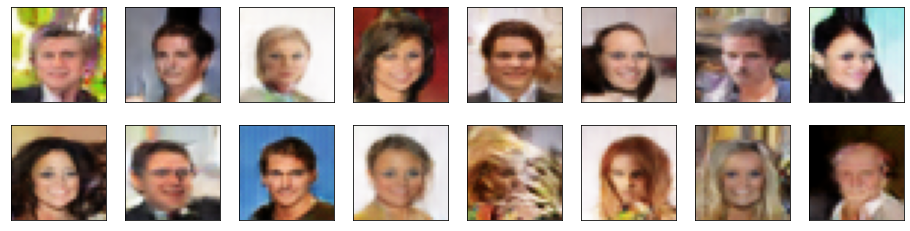

In [478]:
_ = view_samples(-1, samples)